# "Fourth" attempt at building a RISE explainer for embedded spaces

After going back to the previous notebooks, we noticed that we had left out the power multiplication factor 20 in the exponential that initially gave us our most stable results (also leading to all the other attempts, because they seemed reasonable). After trying it out again, this seemed to really improve results.

In this notebook we revisit this factor. We add it in the explain method and see what the results are on different images and we vary the value of the factor to find a optimum.

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from tensorflow.keras import backend as K
from skimage.transform import resize
from requests import get
import os
from urllib.parse import urlparse
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import random
import tensorflow as tf
from keras import backend as K


class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)


def load_img(path, target_size):
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


def generate_masks(N, s, p1, model_input_size):
    cell_size = np.ceil(np.array(model_input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model_input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model_input_size[0], y:y + model_input_size[1]]
    masks = masks.reshape(-1, *model_input_size, 1)
    return masks


def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]


def download(url):
    filename = os.path.basename(urlparse(url).path)
    os.system(f"wget {url}")
    return filename


def plot_explainer(image, saliency, ax=None, vmin=None, vmax=None, title="Explanation",
                   do_cbar=True, add_value_limits_to_title=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.get_figure()
    if add_value_limits_to_title:
        if vmin is None:
            vmin_title = saliency.min()
        else:
            vmin_title = vmin
        if vmax is None:
            vmax_title = saliency.max()
        else:
            vmax_title = vmax
        title = f"{title} vmin = {vmin_title:.2f}, vmax = {vmax_title:.2f}"
    ax.set_title(title)
    ax.axis('off')
    ax.imshow(image)
    im = ax.imshow(saliency, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
    if do_cbar:
      plt.colorbar(im, ax=ax)      
    return fig


# from https://stackoverflow.com/a/52897216/1199693
def set_all_the_seeds(seed_value=0):
    os.environ['PYTHONHASHSEED']=str(seed_value)

    random.seed(seed_value)

    np.random.seed(seed_value)

    tf.random.set_seed(seed_value)

    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# import importlib
# importlib.reload(embeddings)

In [ ]:
model = Model()

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


102981632/102967424 [==============================] - 0s 0us/step


In [ ]:
urls = [
        'https://raw.githubusercontent.com/dianna-ai/dianna/279-embeddings/embedding_WIP/cardog.png',
        # 'https://get.pxhere.com/photo/asphalt-car-daylight-dog-dog-collar-land-rover-lying-model-outdoors-pavement-pet-pitbull-range-rover-road-street-suv-travel-vehicle-wheel-1553095.jpg',
        'https://c.pxhere.com/photos/02/85/boxer_dog_boxer_dog_cute_young_puppy_canine_pet-1023459.jpg!s',
        'https://c4.wallpaperflare.com/wallpaper/680/516/923/the-sky-the-city-coupe-panorama-wallpaper-preview.jpg'
        ]
filenames = [download(url) for url in urls]

img_dogcar, x_dogcar = load_img(filenames[0], model.input_size)
img_dog, x_dog = load_img(filenames[1], model.input_size)
img_car, x_car = load_img(filenames[2], model.input_size)

Previously, we used a notebook with a real image of a car and a dog, but the model only (or mostly) saw the car, not the dog. Here we try to create a better image ourselves.

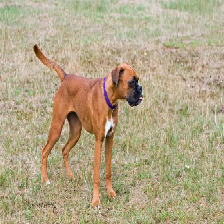

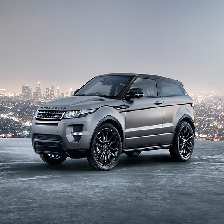

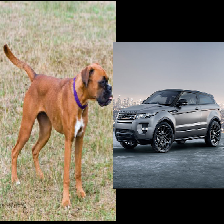

(None, None, None)

In [ ]:
display(img_dog), display(img_car), display(img_dogcar)

In [ ]:
import pandas as pd

def list_top_predictions(predictions, N_top=10):
    label_indices = np.argsort(predictions)[-N_top:]
    prediction_values = np.sort(predictions)[-N_top:]
    labels = [class_name(int(ix)) for ix in label_indices]
    return pd.DataFrame(sorted(zip(labels, prediction_values, label_indices), key=lambda x: x[1], reverse=True),
                        columns=["label", "prediction value", "label index"])

In [ ]:
list_top_predictions(model.run_on_batch(x_dogcar)[0], N_top=10)

49152/35363 [=========================================] - 0s 0us/step


,label,prediction value,label index
0,Rhodesian_ridgeback,0.370260,159
1,bloodhound,0.361404,163
2,redbone,0.123378,168
3,Great_Dane,0.078281,246
4,boxer,0.035786,242
5,vizsla,0.019403,211
6,bull_mastiff,0.006539,243
7,black-and-tan_coonhound,0.001278,165
8,English_foxhound,0.001158,167
9,muzzle,0.000537,676


Unfortunately, in this image, only the dog is detected, now the model doesn't see the car. Argh.

In [ ]:
list_top_predictions(model.run_on_batch(x_car)[0], N_top=10)

,label,prediction value,label index
0,car_wheel,0.522513,479
1,convertible,0.218117,511
2,grille,0.069557,581
3,jeep,0.053431,609
4,pickup,0.046442,717
5,sports_car,0.045553,817
6,beach_wagon,0.024834,436
7,minivan,0.007150,656
8,racer,0.005875,751
9,tow_truck,0.002267,864


In [ ]:
def get_masked_predictions(model, inp, masks, batch_size=10):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    N = len(masks)
    for i in tqdm(range(0, N, batch_size), desc='Getting masked predictions'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    return preds

def explain(model, inp, reference_inp, masks, batch_size=10, preds=None, weight_power=20):
    if preds is None:
        preds = get_masked_predictions(model, inp, masks, batch_size=batch_size)

    reference_pred = model.run_on_batch(reference_inp)
    distances = pairwise_distances(preds, reference_pred, metric='cosine') / 2
    mask_weights = np.exp(-weight_power * distances)

    sal = mask_weights.T.dot(masks.reshape(len(masks), -1)).reshape(-1, *model.input_size)

    normalization = mask_weights.sum()

    sal = sal / normalization
    return sal

Explaining: 100%|██████████| 500/500 [00:43<00:00, 11.37it/s]


weights.shape (5000, 1)


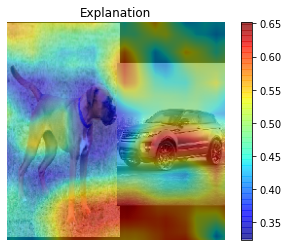

In [ ]:
set_all_the_seeds(3)
_masks = generate_masks(5000, 8, 0.5, model.input_size)
_masked_predictions = get_masked_predictions(model, x_dogcar, _masks)
_sal = explain(model, x_dogcar, x_car, _masks, preds=_masked_predictions)
_fig = plot_explainer(img_dogcar, _sal[0])

Explaining: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


weights.shape (1000, 1)


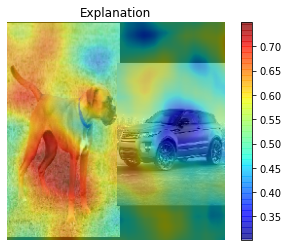

In [ ]:
set_all_the_seeds(4)
_masks = generate_masks(1000, 8, 0.5, model.input_size)
_masked_predictions = get_masked_predictions(model, x_dogcar, _masks)
_sal = explain(model, x_dogcar, x_dog, _masks, preds=_masked_predictions)
_fig = plot_explainer(img_dogcar, _sal[0])

Explaining: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


weights.shape (1000, 1)


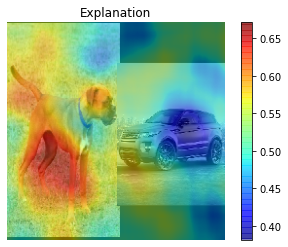

In [ ]:
set_all_the_seeds(4)
_masks = generate_masks(1000, 8, 0.5, model.input_size)
_masked_predictions = get_masked_predictions(model, x_dogcar, _masks)
_sal = explain(model, x_dogcar, x_dog, _masks, preds=_masked_predictions, weight_power=10)
_fig = plot_explainer(img_dogcar, _sal[0])

In [ ]:
set_all_the_seeds(4)
_masks = generate_masks(1000, 8, 0.5, model.input_size)
_masked_predictions = get_masked_predictions(model, x_dogcar, _masks)

Getting masked predictions: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


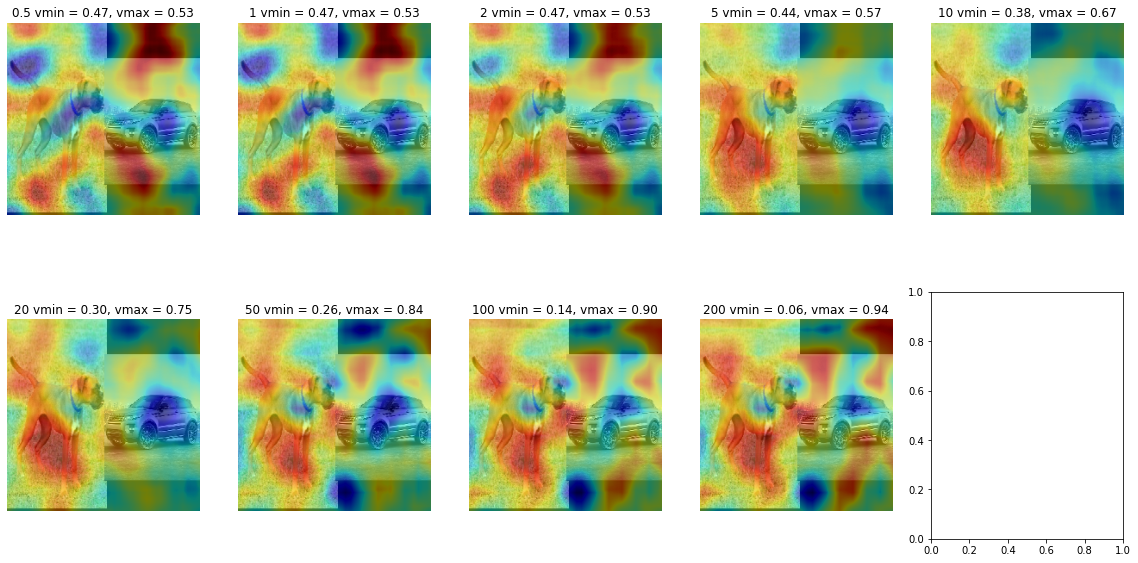

In [ ]:
powers = [0.5, 1, 2, 5, 10, 20, 50, 100, 200]
fig, ax = plt.subplots(2, len(powers)//2 + 1, figsize=(20,10))
for ix, power in enumerate(powers):
  _sal = explain(model, x_dogcar, x_dog, _masks, preds=_masked_predictions, weight_power=power)
  plot_explainer(img_dogcar, _sal[0], ax=ax.flatten()[ix], title=power, add_value_limits_to_title=True, do_cbar=False)
plt.show()

Back in business!

Seems like power 10 is a sweet spot here. 

Let's do the same for dogcar image vs car again.

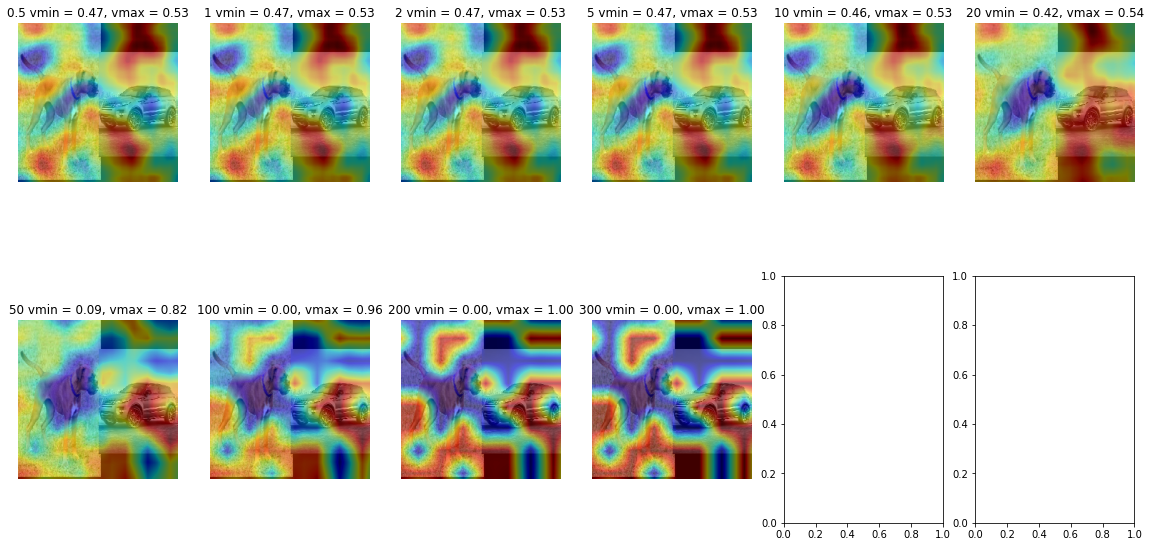

In [ ]:
powers = [0.5, 1, 2, 5, 10, 20, 50, 100, 200, 300]
fig, ax = plt.subplots(2, len(powers)//2 + 1, figsize=(20,10))
for ix, power in enumerate(powers):
  _sal = explain(model, x_dogcar, x_car, _masks, preds=_masked_predictions, weight_power=power)
  plot_explainer(img_dogcar, _sal[0], ax=ax.flatten()[ix], title=power, add_value_limits_to_title=True, do_cbar=False)
plt.show()

Perhaps what we're seeing here is that the model/explainer triggers on the black bars below and above the car. It thinks that it's looking at car wheels and the bars are black...?

At higher powers, the mask pattern clearly shows through. Already at 50 it seems to shine through. This is because the number of "eligible" masks has dropped too low; the high power pushes high distance images away, leaving only a few with low distance.

At what point are we left with just one mask actually? Is that already at 200 in this case? Probably yes, because 300 is the same and we see 0 and 1's, so yeah. Higher values give number overflow.

# Other images

Onwards!

In [ ]:
!wget https://raw.githubusercontent.com/dianna-ai/dianna/279-embeddings/tmp_doggiedog.png

--2022-06-14 14:34:39--  https://raw.githubusercontent.com/dianna-ai/dianna/279-embeddings/tmp_doggiedog.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352971 (345K) [image/png]
Saving to: ‘tmp_doggiedog.png’

tmp_doggiedog.png   100%[===================>] 344.70K  --.-KB/s    in 0.006s  

2022-06-14 14:34:39 (53.8 MB/s) - ‘tmp_doggiedog.png’ saved [352971/352971]



In [ ]:
!wget https://raw.githubusercontent.com/dianna-ai/dianna/279-embeddings/tmp_dogmcdogginson.png

--2022-06-14 14:34:45--  https://raw.githubusercontent.com/dianna-ai/dianna/279-embeddings/tmp_dogmcdogginson.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439173 (429K) [image/png]
Saving to: ‘tmp_dogmcdogginson.png’

tmp_dogmcdogginson. 100%[===================>] 428.88K  --.-KB/s    in 0.008s  

2022-06-14 14:34:45 (51.2 MB/s) - ‘tmp_dogmcdogginson.png’ saved [439173/439173]



In [ ]:
dog1_file_name = 'tmp_doggiedog.png'
dog2_file_name = 'tmp_dogmcdogginson.png'

img_dog1, x_dog1 = load_img(dog1_file_name, model.input_size)
img_dog2, x_dog2 = load_img(dog2_file_name, model.input_size)

In [ ]:
emb_dog1 = model.run_on_batch(x_dog1)
emb_dog2 = model.run_on_batch(x_dog2)

In [ ]:
_masked_predictions = get_masked_predictions(model, x_dog1, _masks)

Getting masked predictions: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


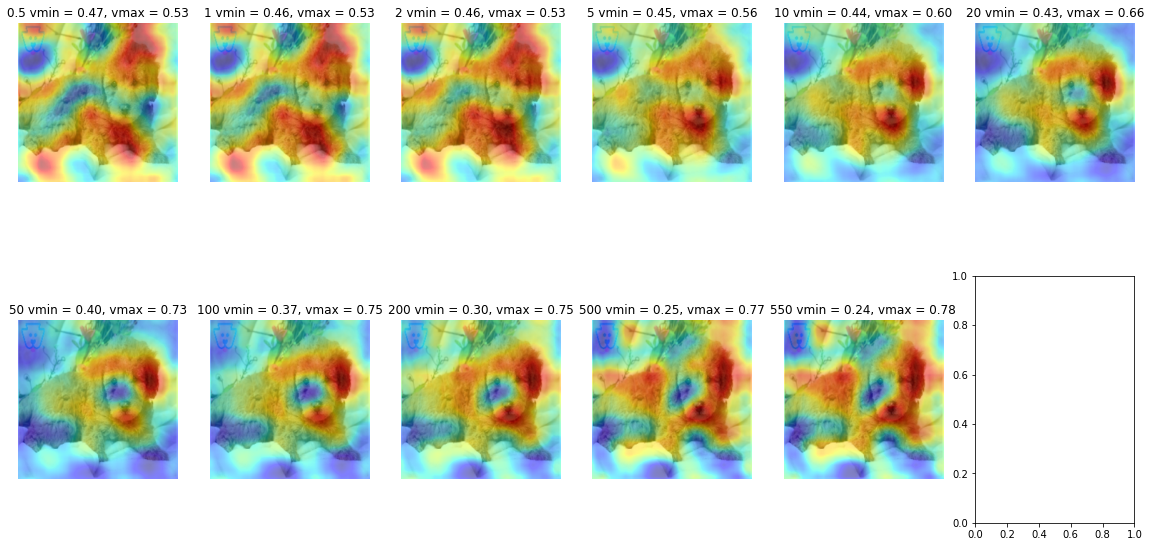

In [ ]:
powers = [0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 550]
fig, ax = plt.subplots(2, len(powers)//2 + 1, figsize=(20,10))
for ix, power in enumerate(powers):
  _sal = explain(model, x_dog1, x_dog2, _masks, preds=_masked_predictions, weight_power=power)
  plot_explainer(img_dog1, _sal[0], ax=ax.flatten()[ix], title=power, add_value_limits_to_title=True, do_cbar=False)
plt.show()

Ok, here the optimal value is clearly different. Plausible explanation: the distances in absolute terms between the two doggies is smaller, meaning the power has to "work harder" to push the lower high distance predictions out of the saliency map. In the car vs dog example, the distances must have been higher in absolute terms (WE SHOULD CHECK) so the power would already push out more masked predictions at lower values.

We can also go higher here in max power than the car-dog example before hitting NaNs and getting to just 1 masked prediction like in that example.

Fascinating!

# ANOTHER ONE

The fly and the bee.

In [ ]:
_urls = ['https://www.publicdomainpictures.net/pictures/50000/velka/liten-fluga.jpg',
         'https://publicdomainpictures.net/pictures/140000/velka/bee-painting.jpg']
_filenames = [download(url) for url in _urls]

img_fly, x_fly = load_img(_filenames[0], model.input_size)
img_bee, x_bee = load_img(_filenames[1], model.input_size)

In [ ]:
_masked_predictions = get_masked_predictions(model, x_bee, _masks)

Getting masked predictions: 100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


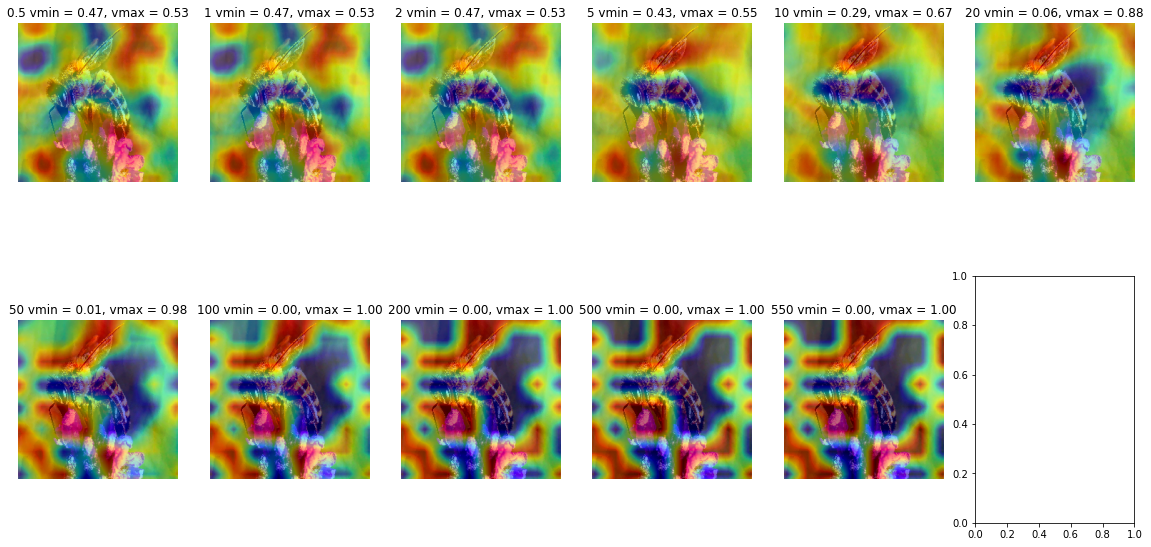

In [ ]:
powers = [0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 550]
fig, ax = plt.subplots(2, len(powers)//2 + 1, figsize=(20,10))
for ix, power in enumerate(powers):
  _sal = explain(model, x_bee, x_fly, _masks, preds=_masked_predictions, weight_power=power)
  plot_explainer(img_bee, _sal[0], ax=ax.flatten()[ix], title=power, add_value_limits_to_title=True, do_cbar=False)
plt.show()

Cool results!

# Next steps

1. Find out whether there is a sensible relation between the distances (average, std, range...) and the power that we subjectively think explains well what it should explain. To do this, we should redo this on a selection of pairs that map out a nice part of the distance range.
2. We should play with the number of masks. Perhaps higher masks give better results still.
3. We should also again definitely check the stability of results under different random seeds.

Going further, we want to do multi-modal things again, but this is for later.

# Wait a minute

If all we're trying to do with the power is "push" out the highest distance masked predictions... why don't we just filter the masks by distances? The parameter can then be a percentage that the user wants to keep for the prediction. This way, there needs to be no calibration of the power to the distance distribution.

In [85]:
def explain2(model, inp, reference_inp, masks, batch_size=10, preds=None, keep_lowest_distance_masks_fraction=0.2):
    if preds is None:
        preds = get_masked_predictions(model, inp, masks, batch_size=batch_size)

    reference_pred = model.run_on_batch(reference_inp)
    distances = pairwise_distances(preds, reference_pred, metric='cosine') / 2
    lowest_distances_indices = np.argsort(distances, axis=0)[:int(len(preds) * keep_lowest_distance_masks_fraction)]

    mask_weights = np.exp(-distances[lowest_distances_indices])
    lowest_distances_masks = masks[lowest_distances_indices]

    sal = mask_weights.T.dot(lowest_distances_masks.reshape(len(lowest_distances_masks), -1)).reshape(-1, *model.input_size)

    normalization = mask_weights.sum()

    sal = sal / normalization
    return sal

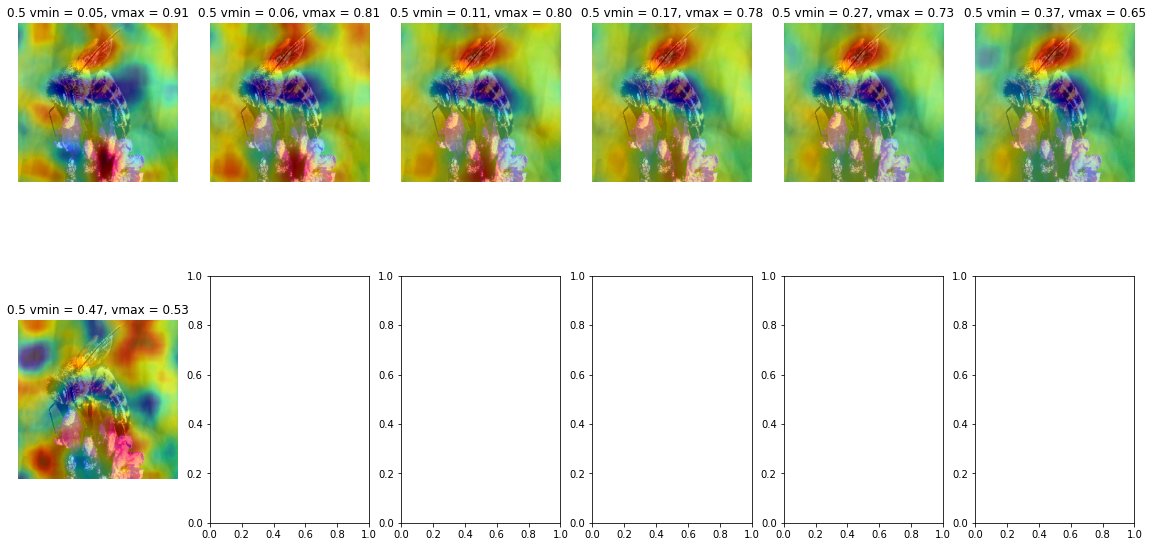

In [86]:
percentages = [1, 2, 5, 10, 20, 50, 100]
fig, ax = plt.subplots(2, len(percentages)//2 + 1, figsize=(20,10))
for ix, percentage in enumerate(percentages):
  _sal = explain2(model, x_bee, x_fly, _masks, preds=_masked_predictions, keep_lowest_distance_masks_fraction=percentage/100)
  plot_explainer(img_bee, _sal[0], ax=ax.flatten()[ix], title=percentage, add_value_limits_to_title=True, do_cbar=False)
plt.show()